## Supervised

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import kagglehub
import shutil
import os

/Users/borandenizduzgun/Desktop/Bremen/Semester-1/IIS/Tutorial-1/Module-4/DogAndBirdSoundClassifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
target_folder = "./dataset"
os.makedirs(target_folder, exist_ok=True)

path_dog = kagglehub.dataset_download("shivarao100/dog-voice-emotion-dataset")
print("Path to dataset files:", path_dog)
shutil.move(path_dog, os.path.join(target_folder, "dog_dataset"))

path_bird = kagglehub.dataset_download("vinayshanbhag/bird-song-data-set")
print("Path to dataset files:", path_bird)
shutil.move(path_bird, os.path.join(target_folder, "bird_dataset"))


In [4]:
def extract_features_robust(file_path):
    """Robust feature extraction with silence trimming"""
    # Load and trim silence
    y, sr = librosa.load(file_path, sr=None)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    
    if len(y_trimmed) == 0:
        print(f"Warning: {file_path} is mostly silent, using original")
        y_trimmed = y
    
    y_trimmed = librosa.util.normalize(y_trimmed)
    
    # Compute features
    S = np.abs(librosa.stft(y_trimmed, n_fft=2048, hop_length=512))
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85)
    
    return np.mean(centroid), np.mean(rolloff)

In [5]:
# =================== MAIN CODE ===================

# Update these paths to your actual directories
bird_dir = "./dataset/bird_dataset/wavfiles/"
dog_dir = "./dataset/dog_dataset/dog_bark_train/"

bird_features = []
dog_features = []

print("=== Processing FIRST 32 Bird Sounds ===")
# Get first 32 .wav files from bird directory
bird_files = list(Path(bird_dir).glob("*.wav"))
# Sort to ensure consistent ordering
bird_files_sorted = sorted(bird_files)[:32]

for i, bird_file in enumerate(bird_files_sorted, 1):
    try:
        centroid, rolloff = extract_features_robust(str(bird_file))
        bird_features.append([centroid, rolloff])
        print(f"  [{i:2d}] {bird_file.name}: C={centroid:.0f} Hz, R={rolloff:.0f} Hz")
    except Exception as e:
        print(f"  Error processing {bird_file.name}: {e}")

print(f"\nProcessed {len(bird_features)} bird files")

print("\n=== Processing FIRST 32 Dog Sounds ===")
# Get first 32 .wav files from dog directory
dog_files = list(Path(dog_dir).glob("*.wav"))
# Sort to ensure consistent ordering
dog_files_sorted = sorted(dog_files)[:32]

for i, dog_file in enumerate(dog_files_sorted, 1):
    try:
        centroid, rolloff = extract_features_robust(str(dog_file))
        dog_features.append([centroid, rolloff])
        print(f"  [{i:2d}] {dog_file.name}: C={centroid:.0f} Hz, R={rolloff:.0f} Hz")
    except Exception as e:
        print(f"  Error processing {dog_file.name}: {e}")

print(f"\nProcessed {len(dog_features)} dog files")

# Check if we have enough files
if len(bird_features) < 2 or len(dog_features) < 2:
    print("\nERROR: Need at least 2 files from each class to train!")
    exit()

# Convert to numpy arrays
bird_features = np.array(bird_features)
dog_features = np.array(dog_features)

# Compute class templates (means)
mu_bird = np.mean(bird_features, axis=0)
mu_dog = np.mean(dog_features, axis=0)

print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"Bird template (mean): Centroid={mu_bird[0]:.0f} Hz, Roll-off={mu_bird[1]:.0f} Hz")
print(f"Dog template (mean): Centroid={mu_dog[0]:.0f} Hz, Roll-off={mu_dog[1]:.0f} Hz")
print(f"Number of bird samples: {len(bird_features)}")
print(f"Number of dog samples: {len(dog_features)}")

=== Processing FIRST 32 Bird Sounds ===
  [ 1] 101308-0.wav: C=3899 Hz, R=4933 Hz
  [ 2] 101308-1.wav: C=3892 Hz, R=4779 Hz
  [ 3] 101308-10.wav: C=3611 Hz, R=5071 Hz
  [ 4] 101308-11.wav: C=3644 Hz, R=5053 Hz
  [ 5] 101308-12.wav: C=4075 Hz, R=5044 Hz
  [ 6] 101308-13.wav: C=3656 Hz, R=5578 Hz
  [ 7] 101308-2.wav: C=3453 Hz, R=5474 Hz
  [ 8] 101308-3.wav: C=3503 Hz, R=5562 Hz
  [ 9] 101308-4.wav: C=3659 Hz, R=4703 Hz
  [10] 101308-5.wav: C=3325 Hz, R=4745 Hz
  [11] 101308-6.wav: C=3631 Hz, R=5163 Hz
  [12] 101308-7.wav: C=3550 Hz, R=5000 Hz
  [13] 101308-8.wav: C=3399 Hz, R=4894 Hz
  [14] 101308-9.wav: C=3763 Hz, R=4906 Hz
  [15] 101427-0.wav: C=4175 Hz, R=5352 Hz
  [16] 101427-1.wav: C=3912 Hz, R=4962 Hz
  [17] 101427-10.wav: C=3779 Hz, R=4988 Hz
  [18] 101427-11.wav: C=3559 Hz, R=5367 Hz
  [19] 101427-2.wav: C=3888 Hz, R=5711 Hz
  [20] 101427-3.wav: C=4141 Hz, R=5317 Hz
  [21] 101427-4.wav: C=3901 Hz, R=4966 Hz
  [22] 101427-5.wav: C=3827 Hz, R=4935 Hz
  [23] 101427-6.wav: C=4190 Hz

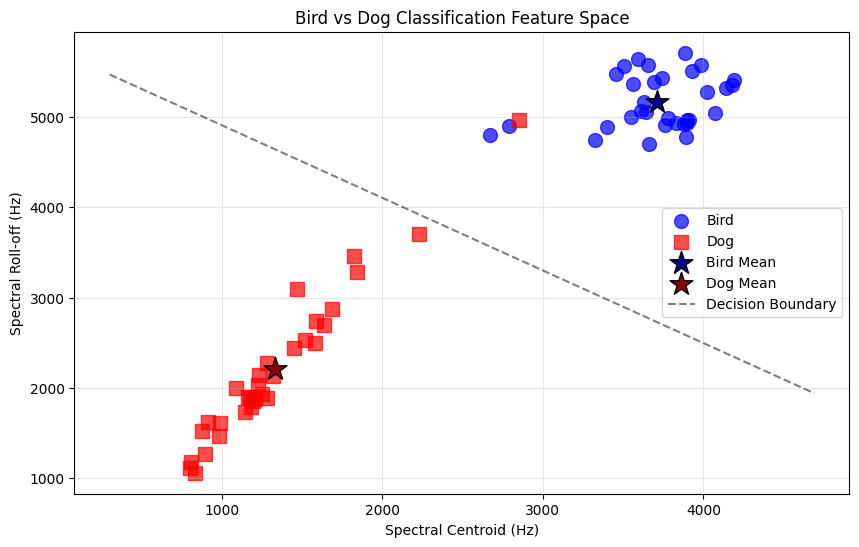

In [6]:
def plot_features(bird_features, dog_features, mu_bird, mu_dog):
    """Visualize the feature space"""
    plt.figure(figsize=(10, 6))
    
    # Plot bird features
    bird_array = np.array(bird_features)
    plt.scatter(bird_array[:, 0], bird_array[:, 1], 
                c='blue', marker='o', s=100, alpha=0.7, label='Bird')
    
    # Plot dog features
    dog_array = np.array(dog_features)
    plt.scatter(dog_array[:, 0], dog_array[:, 1], 
                c='red', marker='s', s=100, alpha=0.7, label='Dog')
    
    # Plot class means
    plt.scatter(mu_bird[0], mu_bird[1], 
                c='darkblue', marker='*', s=300, label='Bird Mean', edgecolors='black')
    plt.scatter(mu_dog[0], mu_dog[1], 
                c='darkred', marker='*', s=300, label='Dog Mean', edgecolors='black')
    
    # Plot decision boundary (midpoint line)
    midpoint = (mu_bird + mu_dog) / 2
    slope = -(mu_dog[0] - mu_bird[0]) / (mu_dog[1] - mu_bird[1]) if (mu_dog[1] - mu_bird[1]) != 0 else 0
    
    # Create line for decision boundary
    x_vals = np.linspace(min(bird_array[:, 0].min(), dog_array[:, 0].min()) - 500,
                        max(bird_array[:, 0].max(), dog_array[:, 0].max()) + 500, 100)
    if slope != 0:
        y_vals = midpoint[1] + slope * (x_vals - midpoint[0])
        plt.plot(x_vals, y_vals, 'k--', alpha=0.5, label='Decision Boundary')
    
    plt.xlabel('Spectral Centroid (Hz)')
    plt.ylabel('Spectral Roll-off (Hz)')
    plt.title('Bird vs Dog Classification Feature Space')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize the feature space
plot_features(bird_features, dog_features, mu_bird, mu_dog)


TESTING ON MIXED TEST FOLDER
Testing folder: ./dataset/mixed_test/
Found 26 test files

[ 1] 97957-13.wav
     Features: C=2620 Hz, R=3681 Hz
     Distances: Bird=1843.15, Dog=1960.66
     Prediction: Bird
     Confidence: ? Low confidence

[ 2] 97957-17.wav
     Features: C=2492 Hz, R=3004 Hz
     Distances: Bird=2482.83, Dog=1410.49
     Prediction: Dog
     Confidence: ✓✓ High confidence

[ 3] 97957-16.wav
     Features: C=2416 Hz, R=3606 Hz
     Distances: Bird=2028.24, Dog=1772.56
     Prediction: Dog
     Confidence: ? Low confidence

[ 4] 97957-14.wav
     Features: C=2580 Hz, R=3337 Hz
     Distances: Bird=2151.57, Dog=1686.40
     Prediction: Dog
     Confidence: ? Low confidence

[ 5] 97957-15.wav
     Features: C=2571 Hz, R=3368 Hz
     Distances: Bird=2129.91, Dog=1700.82
     Prediction: Dog
     Confidence: ? Low confidence

[ 6] dog_39.wav
     Features: C=1407 Hz, R=2449 Hz
     Distances: Bird=3563.11, Dog=255.58
     Prediction: Dog
     Confidence: ✓✓ High confidenc

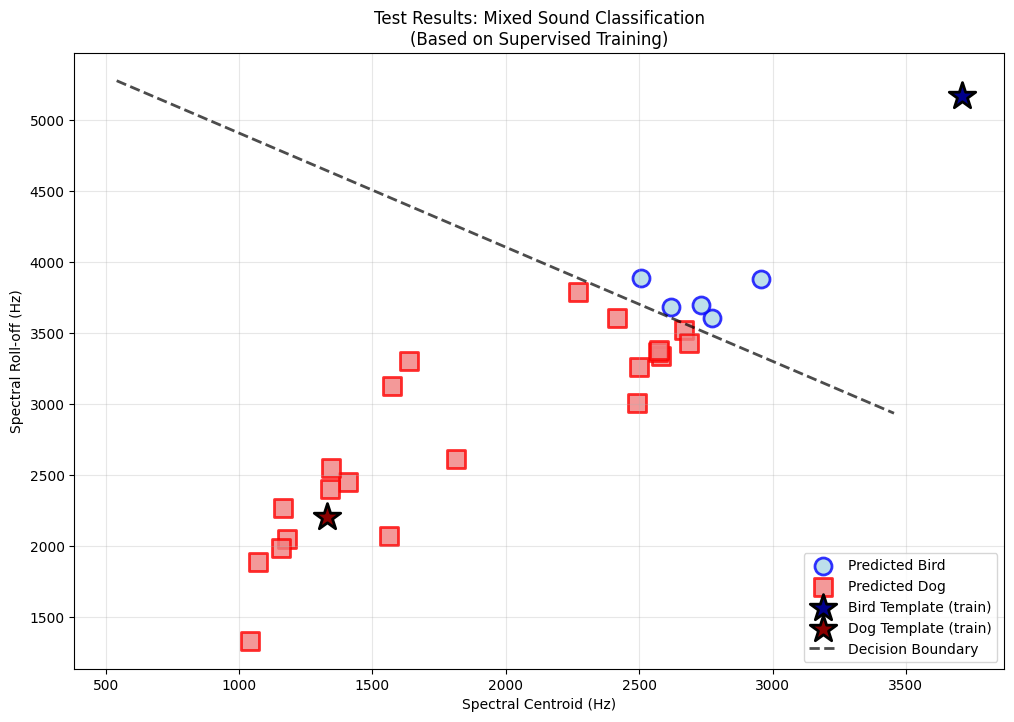


Results saved to: ./dataset/test_results.csv


In [7]:
# =================== TESTING ON MIXED TEST FOLDER ===================

def classify_sound(file_path, mu_bird, mu_dog):
    """Classify a sound file as Bird or Dog"""
    v = extract_features_robust(file_path)
    dist_bird = np.linalg.norm(v - mu_bird)
    dist_dog = np.linalg.norm(v - mu_dog)
    
    if dist_bird < dist_dog:
        return "Bird", dist_bird, dist_dog, v
    else:
        return "Dog", dist_bird, dist_dog, v

# Path to your mixed test folder
mixed_test_dir = "./dataset/mixed_test/"

print("\n" + "="*60)
print("TESTING ON MIXED TEST FOLDER")
print("="*60)
print(f"Testing folder: {mixed_test_dir}")

# Get all test files
test_files = list(Path(mixed_test_dir).glob("*.wav"))
if not test_files:
    print("No .wav files found in test folder!")
    exit()

print(f"Found {len(test_files)} test files\n")

# Test each file
test_results = []
for i, test_file in enumerate(test_files, 1):
    try:
        result, dist_bird, dist_dog, features = classify_sound(str(test_file), mu_bird, mu_dog)
        test_results.append({
            'file': test_file.name,
            'prediction': result,
            'centroid': features[0],
            'rolloff': features[1],
            'dist_bird': dist_bird,
            'dist_dog': dist_dog
        })
        
        print(f"[{i:2d}] {test_file.name}")
        print(f"     Features: C={features[0]:.0f} Hz, R={features[1]:.0f} Hz")
        print(f"     Distances: Bird={dist_bird:.2f}, Dog={dist_dog:.2f}")
        print(f"     Prediction: {result}")
        
        # Confidence indicator
        diff = abs(dist_bird - dist_dog)
        if diff > 1000:
            conf = "✓✓ High confidence"
        elif diff > 500:
            conf = "✓ Medium confidence"
        else:
            conf = "? Low confidence"
        print(f"     Confidence: {conf}\n")
        
    except Exception as e:
        print(f"[{i:2d}] {test_file.name}: ERROR - {e}\n")

# =================== RESULTS SUMMARY ===================

print("\n" + "="*60)
print("TEST RESULTS SUMMARY")
print("="*60)

# Count predictions
bird_count = sum(1 for r in test_results if r['prediction'] == "Bird")
dog_count = sum(1 for r in test_results if r['prediction'] == "Dog")

print(f"Total test files: {len(test_results)}")
print(f"Predicted as Bird: {bird_count} files")
print(f"Predicted as Dog: {dog_count} files")

# Show average feature values for each predicted class
if bird_count > 0:
    bird_features = [r for r in test_results if r['prediction'] == "Bird"]
    avg_bird_centroid = np.mean([r['centroid'] for r in bird_features])
    avg_bird_rolloff = np.mean([r['rolloff'] for r in bird_features])
    print(f"\nPredicted Birds average:")
    print(f"  Centroid: {avg_bird_centroid:.0f} Hz")
    print(f"  Roll-off: {avg_bird_rolloff:.0f} Hz")

if dog_count > 0:
    dog_features = [r for r in test_results if r['prediction'] == "Dog"]
    avg_dog_centroid = np.mean([r['centroid'] for r in dog_features])
    avg_dog_rolloff = np.mean([r['rolloff'] for r in dog_features])
    print(f"\nPredicted Dogs average:")
    print(f"  Centroid: {avg_dog_centroid:.0f} Hz")
    print(f"  Roll-off: {avg_dog_rolloff:.0f} Hz")

# =================== VISUALIZE TEST RESULTS ===================

def plot_test_results(test_results, mu_bird, mu_dog):
    """Visualize test predictions in feature space"""
    plt.figure(figsize=(12, 8))
    
    # Separate predictions
    bird_preds = [r for r in test_results if r['prediction'] == "Bird"]
    dog_preds = [r for r in test_results if r['prediction'] == "Dog"]
    
    # Plot test points
    if bird_preds:
        bird_x = [r['centroid'] for r in bird_preds]
        bird_y = [r['rolloff'] for r in bird_preds]
        plt.scatter(bird_x, bird_y, c='lightblue', marker='o', s=150, 
                   alpha=0.8, label='Predicted Bird', edgecolors='blue', linewidth=2)
    
    if dog_preds:
        dog_x = [r['centroid'] for r in dog_preds]
        dog_y = [r['rolloff'] for r in dog_preds]
        plt.scatter(dog_x, dog_y, c='lightcoral', marker='s', s=150, 
                   alpha=0.8, label='Predicted Dog', edgecolors='red', linewidth=2)
    
    # Plot training templates
    plt.scatter(mu_bird[0], mu_bird[1], c='darkblue', marker='*', 
               s=400, label='Bird Template (train)', edgecolors='black', linewidth=2)
    plt.scatter(mu_dog[0], mu_dog[1], c='darkred', marker='*', 
               s=400, label='Dog Template (train)', edgecolors='black', linewidth=2)
    
    # Add decision boundary
    midpoint = (mu_bird + mu_dog) / 2
    slope = -(mu_dog[0] - mu_bird[0]) / (mu_dog[1] - mu_bird[1]) if (mu_dog[1] - mu_bird[1]) != 0 else 0
    
    # Create decision boundary line
    x_min = min([r['centroid'] for r in test_results]) - 500
    x_max = max([r['centroid'] for r in test_results]) + 500
    x_vals = np.linspace(x_min, x_max, 100)
    
    if slope != 0:
        y_vals = midpoint[1] + slope * (x_vals - midpoint[0])
        plt.plot(x_vals, y_vals, 'k--', alpha=0.7, label='Decision Boundary', linewidth=2)
    
    plt.xlabel('Spectral Centroid (Hz)')
    plt.ylabel('Spectral Roll-off (Hz)')
    plt.title('Test Results: Mixed Sound Classification\n(Based on Supervised Training)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot the test results
if test_results:
    plot_test_results(test_results, mu_bird, mu_dog)

# =================== SAVE RESULTS TO FILE ===================

# Save results to CSV for analysis
import csv
csv_path = "./dataset/test_results.csv"
with open(csv_path, 'w', newline='') as csvfile:
    fieldnames = ['file', 'prediction', 'centroid', 'rolloff', 'dist_bird', 'dist_dog']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for result in test_results:
        writer.writerow(result)

print(f"\nResults saved to: {csv_path}")